In [1]:
%pip install --upgrade keras

Note: you may need to restart the kernel to use updated packages.


Crear set de datos

In [2]:
import pandas as pd

# Cargar los archivos con el separador adecuado (tabulación)
entities_df = pd.read_csv('entities_train.csv', sep='\t')
abstracts_df = pd.read_csv('abstracts_train.csv', sep='\t')
relations_df = pd.read_csv('relations_train.csv', sep='\t')

# Asegurarse de que todos los identificadores de 'abstract_id' sean strings
entities_df['abstract_id'] = entities_df['abstract_id'].astype(str)
abstracts_df['abstract_id'] = abstracts_df['abstract_id'].astype(str)
relations_df['abstract_id'] = relations_df['abstract_id'].astype(str)

# Unir los resúmenes con las relaciones usando 'abstract_id'
merged_df = pd.merge(relations_df, abstracts_df[['abstract_id', 'abstract', 'title']], on='abstract_id', how='inner')

# Unir la información de las entidades, primero para 'entity_1' y luego para 'entity_2'
merged_df = pd.merge(merged_df, entities_df[['entity_ids', 'mention', 'type', 'abstract_id']],
                     left_on=['abstract_id', 'entity_1_id'],
                     right_on=['abstract_id', 'entity_ids'],
                     how='inner')

# Renombrar las columnas para la entidad 1
merged_df.rename(columns={'mention': 'entity_1_mention', 'type': 'entity_1_type'}, inplace=True)

# Unir nuevamente con las entidades para obtener la entidad 2
merged_df = pd.merge(merged_df, entities_df[['entity_ids', 'mention', 'type', 'abstract_id']],
                     left_on=['abstract_id', 'entity_2_id'],
                     right_on=['abstract_id', 'entity_ids'],
                     how='inner')

# Renombrar las columnas para la entidad 2
merged_df.rename(columns={'mention': 'entity_2_mention', 'type': 'entity_2_type'}, inplace=True)

# Revisar las columnas después de las fusiones para identificar los nombres correctos
print("Columnas disponibles después de la fusión:", merged_df.columns)


# Verificar el DataFrame de entrenamiento
print(merged_df.head())

# Guardar el DataFrame en un archivo CSV para futuros usos



Columnas disponibles después de la fusión: Index(['id', 'abstract_id', 'type_x', 'entity_1_id', 'entity_2_id', 'novel',
       'abstract', 'title', 'entity_ids_x', 'entity_1_mention', 'type_y',
       'entity_ids_y', 'entity_2_mention', 'entity_2_type'],
      dtype='object')
   id abstract_id       type_x entity_1_id entity_2_id novel  \
0   0     1353340  Association         410     D007966    No   
1   0     1353340  Association         410     D007966    No   
2   0     1353340  Association         410     D007966    No   
3   0     1353340  Association         410     D007966    No   
4   0     1353340  Association         410     D007966    No   

                                            abstract  \
0  We report on a new allele at the arylsulfatase...   
1  We report on a new allele at the arylsulfatase...   
2  We report on a new allele at the arylsulfatase...   
3  We report on a new allele at the arylsulfatase...   
4  We report on a new allele at the arylsulfatase...   

 

In [3]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73910 entries, 0 to 73909
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                73910 non-null  int64 
 1   abstract_id       73910 non-null  object
 2   type_x            73910 non-null  object
 3   entity_1_id       73910 non-null  object
 4   entity_2_id       73910 non-null  object
 5   novel             73910 non-null  object
 6   abstract          73910 non-null  object
 7   title             73910 non-null  object
 8   entity_ids_x      73910 non-null  object
 9   entity_1_mention  73910 non-null  object
 10  type_y            73910 non-null  object
 11  entity_ids_y      73910 non-null  object
 12  entity_2_mention  73910 non-null  object
 13  entity_2_type     73910 non-null  object
dtypes: int64(1), object(13)
memory usage: 7.9+ MB


In [4]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Asumiendo que merged_df ya está creado y contiene las columnas 'abstract' y 'type_x' (que es la relación)

# 1. Convertir los abstracts a minúsculas
merged_df['abstract'] = merged_df['abstract'].str.lower()

# Verificar que se haya hecho la conversión a minúsculas
print("Abstracts en minúsculas:\n", merged_df['abstract'].head())

# 2. Tokenización y Padding

# Parámetros de tokenización
max_words = 10000  # Número máximo de palabras a mantener en el vocabulario
max_len = 100  # Longitud máxima de las secuencias (después del padding)

# Crear el tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")  # OOV es para palabras fuera del vocabulario
tokenizer.fit_on_texts(merged_df['abstract'])

# Convertir los abstracts a secuencias de tokens
sequences = tokenizer.texts_to_sequences(merged_df['abstract'])

# Aplicar padding a las secuencias para que todas tengan la misma longitud
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# Verificar las primeras secuencias tokenizadas y con padding
print("Primeras secuencias tokenizadas y con padding:\n", padded_sequences[:5])

# 3. Preparar las etiquetas (Relation Type)
# Convertir las relaciones en etiquetas numéricas usando LabelEncoder
label_encoder = LabelEncoder()
# Concatenate the columns to create a combined feature for relationship
merged_df['combined_type'] = merged_df['type_y'] + '~' + merged_df['type_x'] + '~' + merged_df['entity_2_type']
# Apply label encoding to the combined feature
merged_df['type_x'] = label_encoder.fit_transform(merged_df['combined_type'])
# Verificar las etiquetas convertidas
print("Etiquetas de relación convertidas a números:\n", merged_df['type_x'].head())

# Ahora tienes `padded_sequences` (que es la entrada para el modelo) y las etiquetas numéricas `merged_df['type_x']`

# Verificación final
print("Tamaño del conjunto de secuencias con padding:", padded_sequences.shape)
print("Tamaño del conjunto de etiquetas:", merged_df['type_x'].shape)


2024-11-18 08:22:59.160879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 08:22:59.241480: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 08:22:59.266544: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 08:22:59.341355: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Abstracts en minúsculas:
 0    we report on a new allele at the arylsulfatase...
1    we report on a new allele at the arylsulfatase...
2    we report on a new allele at the arylsulfatase...
3    we report on a new allele at the arylsulfatase...
4    we report on a new allele at the arylsulfatase...
Name: abstract, dtype: object
Primeras secuencias tokenizadas y con padding:
 [[  22  416   24    7  372  129   49    2 8097    7 6885  781 1271 4842
   475 9347 9348 6886    5   11  129 8376    7 1498   11   15  686 2694
     5    2 8097   29  183   15 6039   13 1562    5  490    8  786   11
   455  766  475 6886    2 8376    8 1562  299   15   33    6  501 4538
  6885   82    7 1002    4  841 6885  526    3  169  133   24   42  339
  1078    2  129    4 3054   20    6 6886  252  227 9349    2 7691   11
   267 5027    4 4538 6885   82   44    2 1262    4 7506 1050    5 6886
     0    0]
 [  22  416   24    7  372  129   49    2 8097    7 6885  781 1271 4842
   475 9347 9348 6886    5   11 

LSTM

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Parámetros del modelo
vocab_size = 10000  # Tamaño del vocabulario (debe coincidir con el tokenizer)
embedding_dim = 64  # Dimensionalidad del espacio de embedding
max_len = 100  # Longitud máxima de las secuencias (después del padding)

# Construir el modelo secuencial
model = Sequential()

# 1. Capa de Embedding
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))

# 2. Capa LSTM
model.add(LSTM(64, return_sequences=False))

# 3. Capa de Dropout para evitar sobreajuste
model.add(Dropout(0.5))

# 4. Capa final de clasificación (Dense)
# Ajusta el número de neuronas en la última capa según el número de clases que tengas (número de relaciones)
num_classes = len(label_encoder.classes_)  # Número de clases (relaciones)
model.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Resumen del modelo
model.summary()

# Entrenar el modelo
history = model.fit(padded_sequences, merged_df['type_x'], epochs=10, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1731918198.553673    7304 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731918198.568049    7304 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731918198.568196    7304 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731918198.573773    7304 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731918198.573854    7304 cuda_e

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2024-11-18 08:23:21.405771: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1848/1848 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.2972 - loss: 2.6232 - val_accuracy: 0.1488 - val_loss: 3.2134
Epoch 2/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.4205 - loss: 1.7265 - val_accuracy: 0.1644 - val_loss: 3.2765
Epoch 3/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.4192 - loss: 1.6434 - val_accuracy: 0.1685 - val_loss: 3.2618
Epoch 4/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 36s 20ms/step - accuracy: 0.4229 - loss: 1.5899 - val_accuracy: 0.1546 - val_loss: 3.2451
Epoch 5/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - accuracy: 0.4233 - loss: 1.5671 - val_accuracy: 0.1563 - val_loss: 3.2679
Epoch 6/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - accuracy: 0.4285 - loss: 1.5450 - val_accuracy: 0.1424 - val_loss: 3.2938
Epoch 7/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.4265 - loss: 1.5340 - val_accuracy: 0.1655 - val_loss: 3.2772
Epoch 8/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.4315 - loss: 1.51

In [6]:
# Evaluar el modelo en los datos de validación
loss, accuracy = model.evaluate(padded_sequences, merged_df['type_x'], verbose=2)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")


2310/2310 - 22s - 9ms/step - accuracy: 0.4029 - loss: 1.7325
Loss: 1.732484221458435
Accuracy: 0.4028548300266266


In [7]:
model.save('relationship_model_lstm.h5')

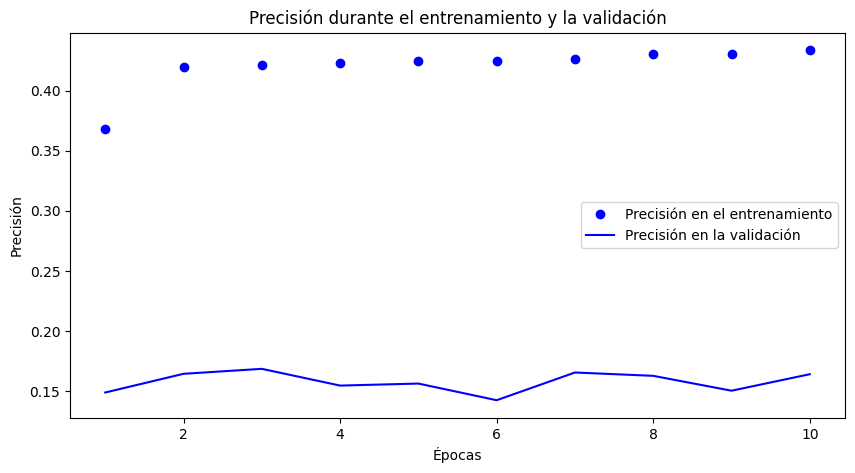

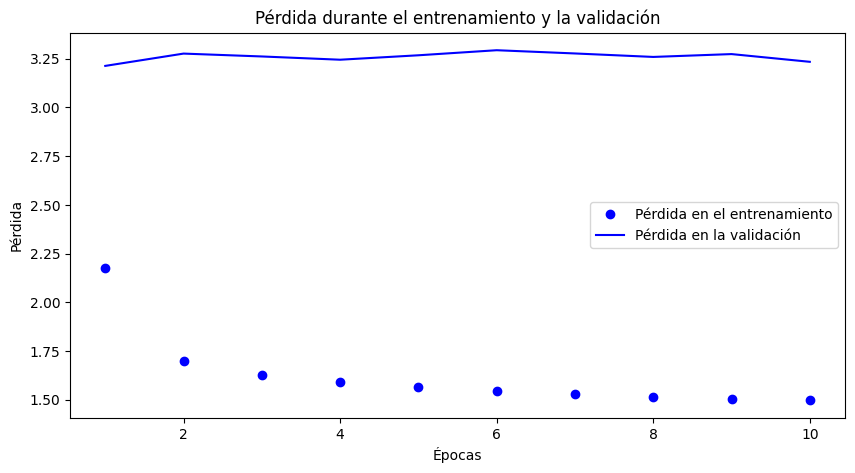

In [8]:
import matplotlib.pyplot as plt

# Extraer los datos de precisión y pérdida del historial de entrenamiento
history_dict = history.history
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(accuracy) + 1)

# Graficar la precisión
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'bo', label='Precisión en el entrenamiento')
plt.plot(epochs, val_accuracy, 'b', label='Precisión en la validación')
plt.title('Precisión durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar la pérdida
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida en la validación')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

# Parámetros del modelo
vocab_size = 10000  # Tamaño del vocabulario
embedding_dim = 64  # Dimensión del embedding
max_len = 100  # Longitud máxima de las secuencias
num_classes = len(label_encoder.classes_)  # Número de clases (relaciones)

# Construir el modelo secuencial
model_rnn = Sequential()

# Capa de Embedding
model_rnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))

# Capa Simple RNN
model_rnn.add(SimpleRNN(64, return_sequences=False))

# Capa de Dropout
model_rnn.add(Dropout(0.5))

# Capa densa de clasificación
model_rnn.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
model_rnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Resumen del modelo
model_rnn.summary()

# Entrenar el modelo
history_rnn = model_rnn.fit(padded_sequences, merged_df['type_x'], epochs=10, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


I0000 00:00:1731918590.406459    7406 service.cc:146] XLA service 0x7f0780004ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731918590.406504    7406 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-11-18 08:29:50.459498: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


   9/1848 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - accuracy: 0.0379 - loss: 3.8449

I0000 00:00:1731918592.418329    7406 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1848/1848 ━━━━━━━━━━━━━━━━━━━━ 56s 28ms/step - accuracy: 0.3517 - loss: 2.3376 - val_accuracy: 0.1891 - val_loss: 3.2401
Epoch 2/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 49s 26ms/step - accuracy: 0.4152 - loss: 1.6829 - val_accuracy: 0.1690 - val_loss: 3.1585
Epoch 3/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 51s 28ms/step - accuracy: 0.4157 - loss: 1.6320 - val_accuracy: 0.2067 - val_loss: 3.1178
Epoch 4/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 49s 27ms/step - accuracy: 0.4171 - loss: 1.6122 - val_accuracy: 0.1946 - val_loss: 3.1979
Epoch 5/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 49s 27ms/step - accuracy: 0.4182 - loss: 1.6030 - val_accuracy: 0.1991 - val_loss: 3.1907
Epoch 6/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 51s 27ms/step - accuracy: 0.4186 - loss: 1.5816 - val_accuracy: 0.2088 - val_loss: 3.2207
Epoch 7/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 51s 28ms/step - accuracy: 0.4175 - loss: 1.5807 - val_accuracy: 0.1952 - val_loss: 3.2728
Epoch 8/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 50s 27ms/step - accuracy: 0.4165 - loss: 1.57

In [10]:
# Evaluar el modelo RNN en los datos de validación
loss_rnn, accuracy_rnn = model_rnn.evaluate(padded_sequences, merged_df['type_x'], verbose=2)
print(f"Loss (RNN): {loss_rnn}")
print(f"Accuracy (RNN): {accuracy_rnn}")


2310/2310 - 28s - 12ms/step - accuracy: 0.3946 - loss: 1.7906
Loss (RNN): 1.7905910015106201
Accuracy (RNN): 0.3946286141872406


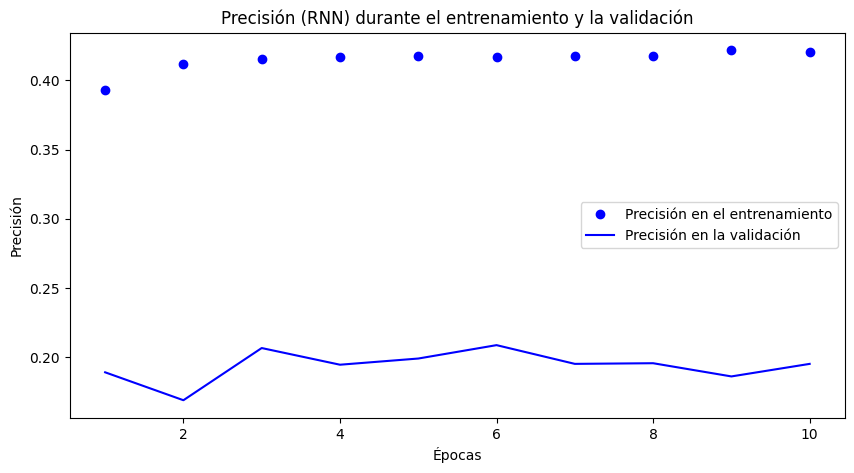

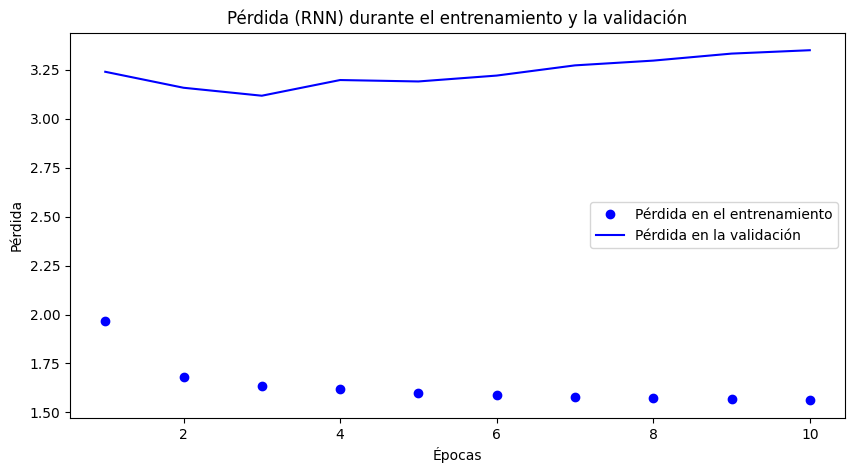

In [11]:
import matplotlib.pyplot as plt

# Extraer los datos de precisión y pérdida del historial de entrenamiento del RNN
history_dict_rnn = history_rnn.history
accuracy_rnn = history_dict_rnn['accuracy']
val_accuracy_rnn = history_dict_rnn['val_accuracy']
loss_rnn = history_dict_rnn['loss']
val_loss_rnn = history_dict_rnn['val_loss']

epochs = range(1, len(accuracy_rnn) + 1)

# Graficar la precisión (RNN)
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy_rnn, 'bo', label='Precisión en el entrenamiento')
plt.plot(epochs, val_accuracy_rnn, 'b', label='Precisión en la validación')
plt.title('Precisión (RNN) durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar la pérdida (RNN)
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_rnn, 'bo', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss_rnn, 'b', label='Pérdida en la validación')
plt.title('Pérdida (RNN) durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()



In [12]:
model.save('relationship_model_rnn.h5')

In [10]:
from transformers import TFAlbertForSequenceClassification, AlbertTokenizer

# Cargar el tokenizer y el modelo preentrenado de ALBERT
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
albert_model = TFAlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=num_classes)

# Preprocesar los textos
encoded_inputs = encode_texts(merged_df['abstract'], max_len=100)

# Compilar el modelo ALBERT
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
albert_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history_albert = albert_model.fit(
    {'input_ids': encoded_inputs['input_ids'], 'attention_mask': encoded_inputs['attention_mask']},
    merged_df['type_x'],
    epochs=3,
    batch_size=16,
    validation_split=0.2
)



ImportError: 
AlbertTokenizer requires the SentencePiece library but it was not found in your environment. Checkout the instructions on the
installation page of its repo: https://github.com/google/sentencepiece#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.
